# Orders

✏️ **Exercise**

Today, we will investigate the **orders**, and their associated **review score**.

👉 Our goal is to create a DataFrame with the following features:


| feature_name 	| type 	| description 	|
|:---	|:---:	|:---	|
| `order_id` 	| str 	| the id of the order 	|
| `wait_time` 	| float 	| the number of days between order_date and delivered_date 	|
| `expected_wait_time` 	| float 	| the number of days between order_date and estimated_delivery_date 	|
| `delay_vs_expected` 	| float 	| if the actual delivery date is later than the estimated delivery date, returns the number of days between the two dates, otherwise return 0 	|
| `order_status` 	| str 	| the status of the order 	|
| `dim_is_five_star` 	| int 	| 1 if the order received a five-star review, 0 otherwise 	|
| `dim_is_one_star` 	| int 	| 1 if the order received a one_star, 0 otherwise 	|
| `review_score` 	| int 	| from 1 to 5 	|
| `number_of_products` 	| int 	| number of products that the order contains 	|
| `number_of_sellers` 	| int 	| number of sellers involved in the order 	|
| `price` 	| float 	| total price of the order paid by customer 	|
| `freight_value` 	| float 	| value of the freight paid by customer 	|
| `distance_customer_seller` 	| float 	| the distance in km between customer and seller (optional) 	|  
  
⚠️ We also want to filter out "non-delivered" orders, unless explicitly specified, otherwise we cannot compute the potential delays.

❓ **Your challenge**: 

- Implement each feature as a separate method within the `Order` class available at `olist/order.py`
- Then, create a method `get_training_data()` that returns the complete DataFrame **without `NaN`s**.

💡 Suggested methodology:
- Use the notebook below to write and test your code step-by-step first
- Then copy the code into `order.py` once you are certain of your code logic
- Focus on the data manipulation logic now, we will analyse the dataset visually in the next challenges

🔥 Notebook best practices (must-read) 👇

<details>
    <summary>▸ <i>click here</i></summary>

From now on, exploratory notebooks are going to become pretty long, and we strongly advise you to follow these notebook principles:
- Code your logic so that your Notebook can always be ran from top to bottom without crashing (Cell --> Run All)
- Name your variables carefully 
- Use dummy names such as `tmp` or `_` for intermediary steps when you know you won't need them for long
- Clear your code and merge cells when relevant to minimize Notebook size (`Shift-M`)
- Hide your cell output if you don't need to see it anymore (double-click on the red `Out[]:` section to the left of your cell).
- Make heavy use of jupyter nbextention `Collapsible Headings` and `Table of Content` (call a TA if you can't find them)
- Use the following shortcuts 
    - `a` to insert a cell above
    - `b` to insert a cell below
    - `dd` to delete a cell
    - `esc` and `arrows` to move between cells
    - `Shift-Enter` to execute cell and move focus to the next one
    - use `Shift + Tab` when you are between method brackets e.g. `groupby()` to get the docs! Repeat a few times to open it permanently

</details>





In [1]:
# Auto reload imported module every time a jupyter cell is executed (handy for olist.order.py updates)
%load_ext autoreload
%autoreload 2

In [2]:
# Import usual modules
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Import olist data
from olist.data import Olist
olist = Olist()
data = olist.get_data()

In [4]:
# What datasets do we have access to now ? 
data.keys()

dict_keys(['sellers', 'product_category_name_translation', 'orders', 'order_items', 'customers', 'geolocation', 'order_payments', 'order_reviews', 'products'])

In [5]:
orders = data['orders'].copy() # good practice to be sure not to modify your `data` variable

assert(orders.shape == (99441, 8))

## 1. Code `order.py`

### a) `get_wait_time`
    ❓ Return a Dataframe with:
           order_id, wait_time, expected_wait_time, delay_vs_expected, order_status


🎁 We give you the pseudo-code below 👇 for this first method:

> 1. Inspect the `orders` dataframe
2. Filter the dataframe on `delivered orders`
3. Handle `datetime`
    - Take time to understand what python [`datetime`](https://docs.python.org/3/library/datetime.html) objects are
    - and convert dates from "string" type to "pandas.datetime' using [`pandas.to_datetime()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html)
4. Compute `wait_time`
5. Compute `expected_wait_time`
6. Compute `delay_vs_expected`
7. Check the new dataframe 
8. Once you are satisfied with your code, you can carefully copy-paste it from the notebook to to `olist/order.py`

<details>
    <summary>💡Hint</summary>

For both `wait_time` and `delay_vs_expected`, you need to subtract the relevant dates/timestamps to get the time difference between the `pandas.datetime` objects. Then, you can either use [`datetime.timedelta()`](https://docs.python.org/3/library/datetime.html#timedelta-objects) or [`np.timedelta64()`](https://numpy.org/doc/stable/reference/arrays.datetime.html#datetime-and-timedelta-arithmetic) to find out how many days that subtraction represents!

</details>

In [6]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [7]:
# YOUR CODE HERE
orders = orders.query("order_status =='delivered'")
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [8]:
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_approved_at'] = pd.to_datetime(orders['order_approved_at'])
orders['order_delivered_carrier_date'] = pd.to_datetime(orders['order_delivered_carrier_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
orders['order_estimated_delivery_date'] = pd.to_datetime(orders['order_estimated_delivery_date'])
orders.dtypes


order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object

In [9]:
orders['wait_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).astype('timedelta64[h]')
orders['expected_wait_time'] = (orders['order_estimated_delivery_date'] - orders['order_purchase_timestamp']).astype('timedelta64[h]')
orders['delay_vs_expected'] = (orders['expected_wait_time'] - orders['wait_time'])



# orders['wait_time'] = pd.to_datetime(orders['wait_time'])
# orders['expected_wait_time'] = pd.to_datetime(orders['expected_wait_time'])
# orders['delay_vs_expected'] = pd.to_datetime(orders['delay_vs_expected'])

# orders.isnull().sum()
# orders.dtypes

def handle_delay(x):
    if x > 0:
        return x
    else:
        return 0

orders.loc[:,'delay_vs_expected'] = orders['delay_vs_expected'].apply(handle_delay)



orders = orders[['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected', 'order_status']]

# orders.drop(['customer_id', 'order_purchase_timestamp', 'order_approved_at','order_delivered_carrier_date'
#                      ,'order_delivered_customer_date', 'order_estimated_delivery_date'],axis=1,inplace=True)
orders
# order_id, wait_time, expected_wait_time, delay_vs_expected, order_status



,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,202.0,373.0,171.0,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,330.0,459.0,129.0,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,225.0,639.0,414.0,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,317.0,628.0,311.0,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,68.0,290.0,222.0,delivered
...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,197.0,446.0,249.0,delivered
99437,63943bddc261676b46f01ca7ac2f7bd8,532.0,563.0,31.0,delivered
99438,83c1379a015df1e13d02aae0204711ab,596.0,729.0,133.0,delivered
99439,11c177c8e97725db2631073c19f07b62,410.0,890.0,480.0,delivered


👀 Check the dataframe you've just created. <br/> 

💪 When your code works, commit it to `olist/order.py` <br/>

🧪 Now, test it by running the following cell 👇 

In [10]:
# Test your code here
from olist.order import Order
Order().get_wait_time()

/Users/fercancercel/code/fercanc/data-context-and-setup/olist/order.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
/Users/fercancercel/code/fercanc/data-context-and-setup/olist/order.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
/Users/fercancercel/code/fercanc/data-context-and-setup/olist/order.py:33: SettingWi

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered
2,47770eb9100c2d0c44946d9cf07ec65d,9.394213,26.639711,0.0,delivered
3,949d5b44dbf5de918fe9c16f97b45f8a,13.208750,26.188819,0.0,delivered
4,ad21c59c0840e6cb83a9ceb5573f8159,2.873877,12.112049,0.0,delivered
...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,8.218009,18.587442,0.0,delivered
99437,63943bddc261676b46f01ca7ac2f7bd8,22.193727,23.459051,0.0,delivered
99438,83c1379a015df1e13d02aae0204711ab,24.859421,30.384225,0.0,delivered
99439,11c177c8e97725db2631073c19f07b62,17.086424,37.105243,0.0,delivered


In [11]:
from nbresult import ChallengeResult
result = ChallengeResult('wait_time', shape=Order().get_wait_time().shape)
result.write(); print(result.check())

/Users/fercancercel/code/fercanc/data-context-and-setup/olist/order.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
/Users/fercancercel/code/fercanc/data-context-and-setup/olist/order.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
/Users/fercancercel/code/fercanc/data-context-and-setup/olist/order.py:33: SettingWi


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/fercancercel/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/fercancercel/code/fercanc/data-orders/tests
plugins: anyio-3.6.1, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 1 item

test_wait_time.py::TestWaitTime::test_wait_time PASSED                   [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/wait_time.pickle

git commit -m 'Completed wait_time step'

git push origin master



### b) `get_review_score`
     ❓ Returns a DataFrame with:
        order_id, dim_is_five_star, dim_is_one_star, review_score

dim_is_$N$_star should contain `1` if review_score=$N$ and `0` otherwise 

<details>
    <summary markdown='span'>Hints</summary>

Think about `Series.map()` or `DataFrame.apply()`
    
</details>

👉 We load the `reviews` for you

In [12]:
reviews = data['order_reviews'].copy()
assert(reviews.shape == (99224,7))
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [13]:
reviews.columns

Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],
      dtype='object')

In [14]:
reviews['dim_is_five_star'] =  0
reviews['dim_is_one_star'] =  0
reviews.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,dim_is_five_star,dim_is_one_star
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,0,0
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,0,0
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,0,0
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,0,0
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,0,0


In [15]:
# YOUR CODE HERE

def fncfive(s):
    if s == 5:
        return 1
    return 0

def fncone(s):
    if s == 1:
        return 1
    return 0

# apply a self created function to a single column in pandas
reviews['dim_is_five_star'] = reviews['review_score'].apply(fncfive)
reviews['dim_is_one_star'] = reviews['review_score'].apply(fncone)

reviews.drop(['review_id','review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp'],axis=1,inplace=True)


reviews

,order_id,review_score,dim_is_five_star,dim_is_one_star
0,73fc7af87114b39712e6da79b0a377eb,4,0,0
1,a548910a1c6147796b98fdf73dbeba33,5,1,0
2,f9e4b658b201a9f2ecdecbb34bed034b,5,1,0
3,658677c97b385a9be170737859d3511b,5,1,0
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,1,0
...,...,...,...,...
99219,2a8c23fee101d4d5662fa670396eb8da,5,1,0
99220,22ec9f0669f784db00fa86d035cf8602,5,1,0
99221,55d4004744368f5571d1f590031933e4,5,1,0
99222,7725825d039fc1f0ceb7635e3f7d9206,4,0,0


Once again, 

👀 Check the dataframe you've just created. <br/> 

💪 When your code works, commit it to `olist/order.py` <br/>

🧪 Now, test it by running the following cell 👇 

In [16]:
# Test your code here
from olist.order import Order
Order().get_review_score()

,order_id,review_score,dim_is_five_star,dim_is_one_star
0,73fc7af87114b39712e6da79b0a377eb,4,0,0
1,a548910a1c6147796b98fdf73dbeba33,5,1,0
2,f9e4b658b201a9f2ecdecbb34bed034b,5,1,0
3,658677c97b385a9be170737859d3511b,5,1,0
4,8e6bfb81e283fa7e4f11123a3fb894f1,5,1,0
...,...,...,...,...
99219,2a8c23fee101d4d5662fa670396eb8da,5,1,0
99220,22ec9f0669f784db00fa86d035cf8602,5,1,0
99221,55d4004744368f5571d1f590031933e4,5,1,0
99222,7725825d039fc1f0ceb7635e3f7d9206,4,0,0


In [17]:
from nbresult import ChallengeResult
result = ChallengeResult('review_score', shape=Order().get_review_score().shape)
result.write(); print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/fercancercel/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/fercancercel/code/fercanc/data-orders/tests
plugins: anyio-3.6.1, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 1 item

test_review_score.py::TestReviewScore::test_review_score PASSED          [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/review_score.pickle

git commit -m 'Completed review_score step'

git push origin master



### c) `get_number_products`:
     ❓ Returns a DataFrame with:
        order_id, number_of_products (total number of products per order)

In [18]:
number_prod = data['order_items'].copy()
number_prod.columns

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value'],
      dtype='object')

In [19]:
# YOUR CODE HERE

number_prod = number_prod.groupby('order_id').count().reset_index()
number_prod['number_of_products'] = number_prod['product_id']

number_prod = number_prod[['order_id','number_of_products']]
number_prod

,order_id,number_of_products
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


🧪 Same routine: 
* check your dataframe, 
* commit your code to `olist/order.py`
* and check that it truly works.

In [20]:
from nbresult import ChallengeResult
result = ChallengeResult('number_products', shape=Order().get_number_products().shape)
result.write(); print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/fercancercel/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/fercancercel/code/fercanc/data-orders/tests
plugins: anyio-3.6.1, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 1 item

test_number_products.py::TestNumberProducts::test_review_score PASSED    [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/number_products.pickle

git commit -m 'Completed number_products step'

git push origin master



### d) `get_number_sellers`:
     ❓ Returns a DataFrame with:
        order_id, number_of_sellers (total number of unique sellers per order)
        
<details>
    <summary>▸ <i>Hint</i></summary>

`pd.Series.nunique()`
</details>

In [21]:
number_seller = data['order_items'].copy()
number_seller.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [22]:
# YOUR CODE HERE

number_seller = number_seller.groupby('order_id').nunique().reset_index()

number_seller['number_of_sellers'] = number_seller['seller_id']

number_seller = number_seller[['order_id','number_of_sellers']]

number_seller


,order_id,number_of_sellers
0,00010242fe8c5a6d1ba2dd792cb16214,1
1,00018f77f2f0320c557190d7a144bdd3,1
2,000229ec398224ef6ca0657da4fc703e,1
3,00024acbcdf0a6daa1e931b038114c75,1
4,00042b26cf59d7ce69dfabb4e55b4fd9,1
...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,1
98662,fffcd46ef2263f404302a634eb57f7eb,1
98663,fffce4705a9662cd70adb13d4a31832d,1
98664,fffe18544ffabc95dfada21779c9644f,1


In [23]:
from nbresult import ChallengeResult
result = ChallengeResult('number_sellers', shape=Order().get_number_sellers().shape)
result.write(); print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/fercancercel/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/fercancercel/code/fercanc/data-orders/tests
plugins: anyio-3.6.1, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 1 item

test_number_sellers.py::TestNumberSellers::test_number_seller PASSED     [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/number_sellers.pickle

git commit -m 'Completed number_sellers step'

git push origin master



### e) `get_price_and_freight`
     Returns a DataFrame with:
        order_id, price, freight_value

<details>
    <summary>▸ <i>Hint</i></summary>

`pd.Series.agg()` allows you to apply one transformation method per column of your groupby object
</details>

In [24]:
price_freight = data['order_items'].copy()
price_freight.shape

(112650, 7)

In [25]:
# YOUR CODE HERE
price_freight = price_freight.groupby('order_id').sum().reset_index()

price_freight = price_freight[['order_id', 'price','freight_value']]

price_freight


,order_id,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,199.90,18.14
...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,299.99,43.41
98662,fffcd46ef2263f404302a634eb57f7eb,350.00,36.53
98663,fffce4705a9662cd70adb13d4a31832d,99.90,16.95
98664,fffe18544ffabc95dfada21779c9644f,55.99,8.72


In [26]:
from nbresult import ChallengeResult
result = ChallengeResult('price', shape=Order().get_price_and_freight().shape)
result.write(); print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/fercancercel/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/fercancercel/code/fercanc/data-orders/tests
plugins: anyio-3.6.1, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 1 item

test_price.py::TestPrice::test_price PASSED                              [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/price.pickle

git commit -m 'Completed price step'

git push origin master



### e) [OPTIONAL] `get_distance_seller_customer` 
**(Try  to code this function only after finishing today's challenges - Skip to next section)**

    ❓ Returns a Dataframe with:
        order_id, distance_seller_customer (the distance in km between customer and seller)

💡Have a look at the `haversine_distance` formula we coded for you in the `olist.utils` module

In [27]:
# YOUR CODE HERE
# SOLUTION:
matching_geo = Order().get_distance_seller_customer()

👀 Check your new dataframe and commit your code to olist/order.py when it works. 





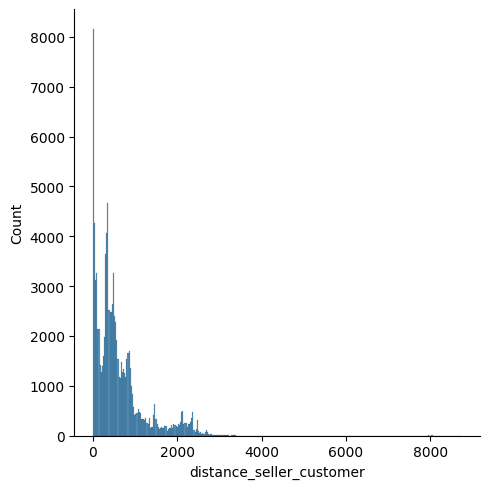

In [28]:
# YOUR CODE HERE

sns.displot(data = matching_geo, x ='distance_seller_customer')

🧪  Test your code

In [29]:
from nbresult import ChallengeResult

result = ChallengeResult('distance',
    mean = Order().get_distance_seller_customer()['distance_seller_customer'].mean())
result.write()
print(result.check())


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/fercancercel/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/fercancercel/code/fercanc/data-orders/tests
plugins: anyio-3.6.1, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 1 item

test_distance.py::TestDistance::test_distance PASSED                     [100%]

============================== 1 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/distance.pickle

git commit -m 'Completed distance step'

git push origin master



## 2. All at once: `get_training_data`

❓ Time to code `get_training_data` making use of your previous coded methods, to gather all order features in one table

In [30]:
# YOUR CODE HERE

training_data = orders.merge(reviews,on='order_id').merge(number_prod,on='order_id').merge(number_seller,on='order_id').merge(price_freight,on='order_id')
# training_data.isna().sum()

training_data = training_data.dropna()
# training_data.isna().sum()
training_data

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,review_score,dim_is_five_star,dim_is_one_star,number_of_products,number_of_sellers,price,freight_value
0,e481f51cbdc54678b7cc49136f2d6af7,202.0,373.0,171.0,delivered,4,0,0,1,1,29.99,8.72
1,53cdb2fc8bc7dce0b6741e2150273451,330.0,459.0,129.0,delivered,4,0,0,1,1,118.70,22.76
2,47770eb9100c2d0c44946d9cf07ec65d,225.0,639.0,414.0,delivered,5,1,0,1,1,159.90,19.22
3,949d5b44dbf5de918fe9c16f97b45f8a,317.0,628.0,311.0,delivered,5,1,0,1,1,45.00,27.20
4,ad21c59c0840e6cb83a9ceb5573f8159,68.0,290.0,222.0,delivered,5,1,0,1,1,19.90,8.72
...,...,...,...,...,...,...,...,...,...,...,...,...
96356,9c5dedf39a927c1b2549525ed64a053c,197.0,446.0,249.0,delivered,5,1,0,1,1,72.00,13.08
96357,63943bddc261676b46f01ca7ac2f7bd8,532.0,563.0,31.0,delivered,4,0,0,1,1,174.90,20.10
96358,83c1379a015df1e13d02aae0204711ab,596.0,729.0,133.0,delivered,5,1,0,1,1,205.99,65.02
96359,11c177c8e97725db2631073c19f07b62,410.0,890.0,480.0,delivered,2,0,0,2,1,359.98,81.18


🧪  Test it below

In [31]:
from nbresult import ChallengeResult
from olist.order import Order
data = Order().get_training_data()

result = ChallengeResult('training',
    shape=data.shape,
    columns=sorted(list(data.columns))
)
result.write()
print(result.check())

/Users/fercancercel/code/fercanc/data-context-and-setup/olist/order.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
/Users/fercancercel/code/fercanc/data-context-and-setup/olist/order.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])
/Users/fercancercel/code/fercanc/data-context-and-setup/olist/order.py:33: SettingWi


============================= test session starts ==============================
platform darwin -- Python 3.10.6, pytest-7.1.3, pluggy-1.0.0 -- /Users/fercancercel/.pyenv/versions/lewagon/bin/python3
cachedir: .pytest_cache
rootdir: /Users/fercancercel/code/fercanc/data-orders/tests
plugins: anyio-3.6.1, asyncio-0.19.0
asyncio: mode=strict
collecting ... collected 2 items

test_training.py::TestTraining::test_training_data_columns PASSED        [ 50%]
test_training.py::TestTraining::test_training_data_shape PASSED          [100%]

============================== 2 passed in 0.01s ===============================


💯 You can commit your code:

git add tests/training.pickle

git commit -m 'Completed training step'

git push origin master



🏁 Congratulations! 

💾 Commit and push your notebook before starting the next challenge.